In [2]:
#Импорт библиотек необходимых для обработки данных
import pandas as pd
import csv
from os import listdir
import librosa
import soundfile as sf
%matplotlib inline
#%matplotlib notebook
from matplotlib import pyplot as plt
import librosa.display as ld
import numpy as np

In [3]:
#Функция визуалиации mfcc
def vis_mfcc(mfccs):
    plt.figure(figsize=(10, 2))
    ld.specshow(mfccs.T, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()


#Функция визуалиации mel-спектограмм
def vis_mel(mel):
    plt.figure(figsize=(10, 2))
    ld.specshow(librosa.power_to_db(mel.T, ref=np.max),
                y_axis='mel',
                fmax=8000,
                x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.tight_layout()


#функция перевода из mel-спектограммы в mfcc
def mel2mfcc(mel):
    return librosa.feature.mfcc(S=librosa.power_to_db(mel))


#загрузчик данных в csv
#НЕ ИСПОЛЬЗУЕТСЯ
def data_loader2csv(is_train, csv_path):
    if is_train:
        dirs = 'train'
    else:
        dirs = 'val'
    headers = 'mel'
    for i in range(1, 21):
        headers += f' mfcc{i}'
    headers += ' is_noisy'
    headers = headers.split()

    df_data = pd.DataFrame(columns=headers)
    file = open(csv_path, 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(headers)
    is_noisy = 'clean noisy'.split()
    for i in is_noisy:
        for speaker in listdir(f'./{dirs}/{i}'):
            for filename in listdir(f'./{dirs}/{i}/{speaker}'):
                file = f'./{dirs}/{i}/{speaker}/{filename}'
                train_load = np.load(file)
                mfcc = mel2mfcc(train_load)
                to_append = f'{filename} '
                for m in mfcc:
                    to_append += f' {np.mean(m)}'
                to_append += f' {i}'
                file = open(csv_path, 'a', newline='')
                with file:
                    writer = csv.writer(file)
                    writer.writerow(to_append.split())


#супер плохой загрузчик данных в npy
def very_uneffective_data_loader_2_npy(is_train, path):
    if is_train: dirs = 'train'
    else: dirs = 'val'
    data = np.array([])
    is_noisy = 'clean noisy'.split()
    for i in is_noisy:
        for speaker in listdir(f'./{dirs}/{i}'):
            for filename in listdir(f'./{dirs}/{i}/{speaker}'):
                file = f'./{dirs}/{i}/{speaker}/{filename}'
                #Переводим данные сразу в MFCC
                if i == 'clean':
                    loader = filename, mel2mfcc(np.load(file)), 0
                else:
                    loader = filename, mel2mfcc(np.load(file)), 1
                data = np.append(data, loader)
    np.save(path, data)
    print('Done!')

### Визуализируем спектограммы из теста

(80, 741) (80, 741)


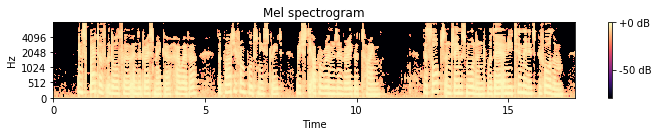

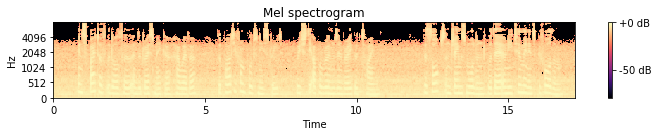

In [216]:
clean_audio, framerate = sf.read('audio_samples/' + '20-205-0000.flac')
noisy_audio, framerate = sf.read('audio_samples/' + '20-205-0000_noisy.wav')
clean_mel = 1 + np.log(1.e-12 +
                       librosa.feature.melspectrogram(clean_audio,
                                                      sr=16000,
                                                      n_fft=1024,
                                                      hop_length=256,
                                                      fmin=20,
                                                      fmax=8000,
                                                      n_mels=80)).T / 10.
noisy_mel = 1 + np.log(1.e-12 +
                       librosa.feature.melspectrogram(noisy_audio,
                                                      sr=16000,
                                                      n_fft=1024,
                                                      hop_length=256,
                                                      fmin=20,
                                                      fmax=8000,
                                                      n_mels=80)).T / 10.
vis_mel(clean_mel)
vis_mel(noisy_mel)
print(clean_mel.T.shape, noisy_mel.T.shape)

Видим, что разница между чистой и зашумленной спектограммой на лицо. Шум представляет собой...

### Переход к MFCC
Mel-спектограммы, отлично описывают природу звука, который слышит человек, что позволяет использовать данные, полученые с mel-спектограмм в качестве признаков для модели.

### Однако 
Mel-спектограммы обладают большой размерностью данных - 80 (n_mels) на 741 (в примере выше).

Для понижения размерности данных (в первую очередь это необходимо потому что не не хватает мощности обработать mel-спектограммы на моем ПК :) ) - возможен переход от mel-спектограмм к Mel-кепстральные коэффициенты

Mel-кепстральные коэффициенты (MFCC) - 

(80, 20) (80, 20)


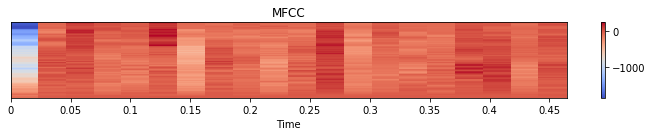

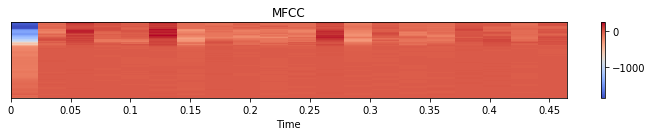

In [217]:
mfcc_clean = mel2mfcc(clean_mel)
mfcc_noisy = mel2mfcc(noisy_mel)
vis_mfcc(mfcc_clean)
vis_mfcc(mfcc_noisy)
print(mfcc_clean.T.shape, mfcc_noisy.T.shape)

И хотя MFCC обладают плохой репутацией в распозновании речи в зашумленных данных, из примера видно, что шум описывается не хуже чем на mel-спектограмме.

### Приведем пример из  тренировочной выборки

C:\Anaconda\lib\site-packages\librosa\core\spectrum.py:901: RuntimeWarning: divide by zero encountered in log10
  log_spec = 10.0 * np.log10(np.maximum(amin, magnitude))


(80, 875) (80, 875)
(80, 20) (80, 20)


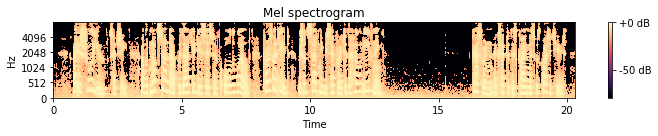

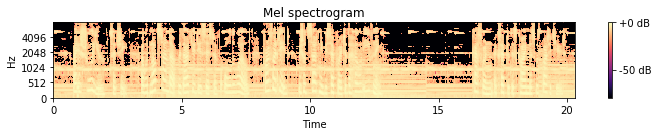

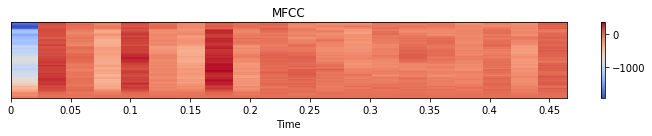

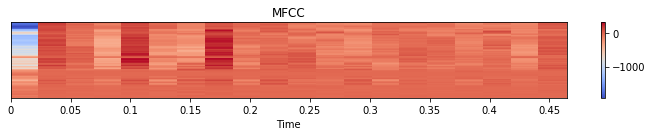

In [218]:
train_example_clean = np.load('.//train//clean//20//20_205_20-205-0004.npy')
train_example_noisy = np.load('.//train//noisy//20//20_205_20-205-0004.npy')
vis_mel(train_example_clean)
vis_mel(train_example_noisy)
vis_mfcc(mel2mfcc(train_example_clean))
vis_mfcc(mel2mfcc(train_example_noisy))
print(train_example_clean.T.shape, train_example_noisy.T.shape)
print(
    mel2mfcc(train_example_clean).T.shape,
    mel2mfcc(train_example_noisy).T.shape)

Также наблюдаем сохранение "шумовых" данных на графике MFCC (явно видно по линии шума на 1024 Hz с mel-спектограммы и ее сохранение на графике MFCC).

### Таким образом
Мы можем выдвинуть гипотезу использования MFCC в качестве входных данных, которые при снижении размерности, с той же вероятностью смогут распознать наличие шума в  исходной mel-спектограмме.

In [ ]:
#Для сбора информации по всех mel-спектограмм из папок в единый файл

very_uneffective_data_loader_2_npy(True,'./data_tr.npy')
very_uneffective_data_loader_2_npy(False,'./data_val.npy')

In [4]:
#Импорт необходимых для построения модели библиотек
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

#Хорошо что есть CUDA :)
train_on_gpu = torch.cuda.is_available()
torch.cuda.current_device()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
#Функция дополнительного преобразования данных. На выходе массив названия файлов и TensorDataset
def data_processing_to_torch(data):
    #Удаляем последствия моего плохого загрузчика данных
    a = [i for i in np.arange(0, data.shape[0], 3)]
    b = [i for i in np.arange(1, data.shape[0], 3)]
    c = [i for i in np.arange(2, data.shape[0], 3)]
    filenames = data[a]
    mfcc_data = np.array(data[b].tolist()).astype(np.float32)
    labels = data[c].astype(np.float32)
    data_torch = TensorDataset(
        torch.from_numpy(mfcc_data).float(),
        torch.from_numpy(labels).long())

    return filenames, data_torch

In [6]:
num_workers = 0
batch_size = 50

#Загружаем и преобразуем данные в нужный формат
val = np.load('./data_val.npy')
train = np.load('./data_tr.npy')
train_files, train_data = data_processing_to_torch(train)
val_files, val_data = data_processing_to_torch(val)

#Инициализируем сэмплеры для перемещивания данных
num_train, num_val = len(train_data), len(val_data)
indices_train, indices_val = list(range(num_train)), list(range(num_val))
np.random.shuffle(indices_train)
np.random.shuffle(indices_val)
#Из валидационной выборки возьмем дополнительно 20 процентов под мини-тест модели
small_test_size = 0.2
split = int(np.floor(small_test_size * num_val))
valid_idx, small_test_idx = indices_val[split:], indices_val[:split]
train_sampler = SubsetRandomSampler(indices_train)
valid_sampler = SubsetRandomSampler(valid_idx)
small_test_sampler = SubsetRandomSampler(small_test_idx)

#Инициализируем загрузчики данных

train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           sampler=train_sampler,
                                           num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_data,
                                         batch_size=batch_size,
                                         sampler=valid_sampler,
                                         num_workers=num_workers)
small_test_loader = torch.utils.data.DataLoader(val_data,
                                                batch_size=batch_size,
                                                sampler=small_test_sampler,
                                                num_workers=num_workers)

In [7]:
#Проверяем работоспособность
dataiter = iter(small_test_loader)
images, labels = dataiter.next()
print(images[0])
print('\n images.shape = ',images.shape, ' | НЕ подходит')
#К сожалению DataLoader выдает не подходящий 3d формат, приходиться в ручную переводить его в 4-мерный
print('\n new images.shape = ',images.view(batch_size, 1, 20, 80).shape, ' | Теперь отлично!')
print('\n labels.shape = ',labels.shape)

tensor([[-1.6173e+02, -2.4704e+02, -2.5297e+02,  ..., -8.7259e+02,
         -8.5250e+02, -1.0828e+03],
        [-9.1370e+00, -9.8357e+00, -2.1952e+00,  ..., -1.3307e+02,
         -1.0740e+02, -1.1478e+02],
        [ 1.7161e+00, -1.5306e+01,  1.9311e+01,  ..., -6.2917e+01,
         -4.7553e+01, -4.4350e+01],
        ...,
        [-4.1568e-01,  6.0706e-01,  6.7889e+00,  ...,  7.7540e+01,
          7.6277e+01,  8.3686e+01],
        [ 5.6508e-01,  5.4142e+00,  2.5064e+01,  ..., -9.1019e+01,
         -1.0423e+02, -8.1187e+01],
        [ 3.9698e+00, -2.2551e+01,  3.8310e+00,  ..., -1.0452e+02,
         -9.7930e+01, -1.1213e+02]])

 images.shape =  torch.Size([50, 20, 80])  | НЕ подходит

 new images.shape =  torch.Size([50, 1, 20, 80])  | Теперь отлично!

 labels.shape =  torch.Size([50])


### Для работы
с 2d массивами с шумовыми данными была выбрана CNN - так как именно алгоритм свертки лушче всего подходит для распознования паттернов шума с высокой точностью.

Архитектура модели была подобрана эмпирически.

In [8]:
class CNNet(nn.Module):
    def __init__(self):
        super(CNNet, self).__init__()

        #Инициализируем слои сети

        #conv layers
        #20x80x1 >> 20x80x16 >> pool2 10x40x16
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        #10x40x16 >> 10x40x32 >> pool2 5x20x32
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        #5x20x32 >> 5x20x64 >> pool5 >> 1x4x64
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        #pool layers
        self.pool2 = nn.MaxPool2d(2, 2)
        self.pool5 = nn.MaxPool2d(5, 5)
        # linear layers
        #(64 * 4 = 256 -> 128)
        self.fc1 = nn.Linear(64 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.fc4 = nn.Linear(16, 8)
        self.fc5 = nn.Linear(8, 1)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

        # Прописывает FeedForward для данных
    def forward(self, x):
        #Так как мы работает не с изобржаениями, а с MFCC - то ReLU в качестве функции активации подходит плохо
        # т.к. не учитывать отрицательные значения коэффициентов нельзя. Поэтому в бой идет гиперболический тангенс!

        x = self.pool2(torch.tanh(self.conv1(x)))
        x = self.pool2(torch.tanh(self.conv2(x)))
        x = self.pool5(torch.tanh(self.conv3(x)))

        # Сплющиваем вектор после Conv layers
        x = x.view(-1, 64 * 4)

        x = self.dropout(x)
        x = torch.tanh(self.fc1(x))
        x = self.dropout(x)
        x = torch.tanh(self.fc2(x))
        x = self.dropout(x)
        x = torch.tanh(self.fc3(x))
        x = self.dropout(x)
        x = torch.tanh(self.fc4(x))
        x = self.dropout(x)
        # на выходе сигмоида определяет класс 1 - если зашумленные данные, 0 - если нет шума
        x = torch.sigmoid(self.fc5(x))

        return x


model = CNNet()
print(model)

if train_on_gpu:
    model.cuda()

CNNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool5): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=8, bias=True)
  (fc5): Linear(in_features=8, out_features=1, bias=True)
  (dropout): Dropout(p=0.25)
)


In [9]:
# в качестве функции потерь используем бинарную кросс-энтропию
criterion = nn.BCELoss()
# в качестве оптимизатора берем лучшее (что я знаю :) ) - Adam
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [91]:
#Кол-во эпох
n_epochs = 30

#Инициализируем минимальную валидационную потерю. Нужна для выбора модели.
#Наверняка ставим минимум в бесконечность
valid_loss_min = np.Inf

for epoch in range(1, n_epochs + 1):

    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # Обучение модели #
    ###################
    #Переводим модель в режим обучения
    model.train()
    for data, target in train_loader:
        # Перводим данные в GPU
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        #переводим данные в нужный для прогнозирования формат
        data = data.view(batch_size, 1, 20, 80)
        target = target.float()
        # Обнуляем градиент
        optimizer.zero_grad()
        #FeedForward
        output = model(data)
        # Считаем потерю на выборке [= batch_size]
        loss = criterion(output, target)
        # BackProp
        loss.backward()
        optimizer.step()
        # Обновляем значение функции потерь на тренировочной выборке
        train_loss += loss.item() * data.size(0)

    ####################
    # Валидация модели #
    ####################
    #Переводим модель в режим расчета
    model.eval()
    for data, target in val_loader:
        # Перводим данные в GPU
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        #переводим данные в нужный для прогнозирования формат
        data = data.view(batch_size, 1, 20, 80)
        target = target.float()
        #FeedForward
        output = model(data)
        loss = criterion(output, target)
        # Обновляем значение функции потерь на валидационной выборке
        valid_loss += loss.item() * data.size(0)

    # Считаем средние потери
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(val_loader.sampler)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    #Если текущая потеря меньше минимальной => cохраняем модель
    if valid_loss <= valid_loss_min:
        print(
            'Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.
            format(valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'CNN_model.pt')
        valid_loss_min = valid_loss

C:\Anaconda\lib\site-packages\torch\nn\functional.py:2016: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch: 1 	Training Loss: 0.334165 	Validation Loss: 0.273560
Validation loss decreased (inf --> 0.273560).  Saving model ...
Epoch: 2 	Training Loss: 0.273409 	Validation Loss: 0.258813
Validation loss decreased (0.273560 --> 0.258813).  Saving model ...
Epoch: 3 	Training Loss: 0.298453 	Validation Loss: 0.232948
Validation loss decreased (0.258813 --> 0.232948).  Saving model ...
Epoch: 4 	Training Loss: 0.292130 	Validation Loss: 0.304127
Epoch: 5 	Training Loss: 0.310146 	Validation Loss: 0.243967
Epoch: 6 	Training Loss: 0.306683 	Validation Loss: 0.306377
Epoch: 7 	Training Loss: 0.311050 	Validation Loss: 0.280578
Epoch: 8 	Training Loss: 0.289403 	Validation Loss: 0.248396
Epoch: 9 	Training Loss: 0.313641 	Validation Loss: 0.225701
Validation loss decreased (0.232948 --> 0.225701).  Saving model ...
Epoch: 10 	Training Loss: 0.283823 	Validation Loss: 0.259473
Epoch: 11 	Training Loss: 0.273851 	Validation Loss: 0.214102
Validation loss decreased (0.225701 --> 0.214102).  Savi

### Лучшая модель на 11-ой итерации
Epoch: 11 	
Training Loss: 0.273851 	

Validation Loss: 0.214102

Validation loss decreased (0.225701 --> 0.214102).

Видно, что модель достаточно хорошо обучается на этих данных, с низкой функцией потерь на обучающейся выборке и на валидационной

In [10]:
#загружаем параметры модели для мини-теста
model.load_state_dict(torch.load('CNN_model.pt'))

In [16]:
#Переменные для подсчета точности
test_loss = 0.0
noisy_correct = 0
noisy_all = 0
clean_correct = 0
clean_all = 0
all_correct = 0
all_total = 0
#Переводим модель в режим расчета
model.eval()
for data, target in small_test_loader:
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    data = data.view(batch_size, 1, 20, 80)
    target = target.float()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)
    pred = output
    #Преобразуем предсказания из веротностей в классы 1 и 0
    vfunc = np.vectorize(lambda x: 1 if x >= 0.5 else 0)
    #переводим из tensor в nupmy
    pred = vfunc(pred.cpu().detach().numpy())
    target = target.long()
    #потом в dataframe......
    preds = pd.DataFrame([target.cpu().detach().numpy(), pred],
                         index=['real', 'pred']).T
    #не самый лучший подсчет точности, но все же работает
    for i in range(len(target.data)):
        if pred[i] == target[i].item():
            all_correct += 1
        all_total += 1
    for k in preds['real'][preds['real'] == 1].index:
        if preds['real'][k] == preds['pred'][k]:
            noisy_correct += 1
        noisy_all += 1
    for z in preds['real'][preds['real'] == 0].index:
        if preds['real'][z] == preds['pred'][z]:
            clean_correct += 1
        clean_all += 1

#считаем потерю
test_loss = test_loss / len(small_test_loader.dataset)
#вывод точности
print('Test Loss: {:.6f}\n'.format(test_loss))
print('\nTest Accuracy of noisy: %2d%% (%2d/%2d)' %
      (100 * noisy_correct / noisy_all, noisy_correct, noisy_all))
print('\nTest Accuracy of clean: %2d%% (%2d/%2d)' %
      (100 * clean_correct / clean_all, clean_correct, clean_all))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' %
      (100. * all_correct / all_total, all_correct, all_total))

Test Loss: 0.040356


Test Accuracy of noisy: 87% (322/368)

Test Accuracy of clean: 96% (419/432)

Test Accuracy (Overall): 92% (741/800)


## Итоговая точность модели варьируется от 92%

Теперь необходимо инициализировать скрипт для теста

Внизу представлены характеристики модели и оптимизатора.

In [212]:
#Параметры модели
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([16, 1, 3, 3])
conv1.bias 	 torch.Size([16])
conv2.weight 	 torch.Size([32, 16, 3, 3])
conv2.bias 	 torch.Size([32])
conv3.weight 	 torch.Size([64, 32, 3, 3])
conv3.bias 	 torch.Size([64])
fc1.weight 	 torch.Size([128, 256])
fc1.bias 	 torch.Size([128])
fc2.weight 	 torch.Size([64, 128])
fc2.bias 	 torch.Size([64])
fc3.weight 	 torch.Size([16, 64])
fc3.bias 	 torch.Size([16])
fc4.weight 	 torch.Size([8, 16])
fc4.bias 	 torch.Size([8])
fc5.weight 	 torch.Size([1, 8])
fc5.bias 	 torch.Size([1])


In [213]:
#Параметры оптимизатора
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {2391819668504: {'step': 14400, 'exp_avg': tensor([[[[-2.8101e-02, -2.4049e-02, -1.3609e-02],
          [-5.6507e-02, -3.7667e-02, -4.6702e-02],
          [ 8.1513e-03, -2.3369e-04,  1.0016e-02]]],


        [[[-1.9293e-03, -6.0367e-04, -3.0474e-03],
          [ 8.0397e-04, -4.6291e-04,  7.7182e-05],
          [ 1.1388e-03,  2.0541e-03,  8.1489e-03]]],


        [[[ 6.7171e-02,  1.1774e-01,  1.9361e-01],
          [ 2.0989e-02, -2.6354e-02, -1.2323e-01],
          [ 5.5172e-02,  1.1618e-01,  1.5526e-01]]],


        [[[-6.8433e-03, -8.1763e-03, -3.7040e-03],
          [-1.5478e-02, -2.0147e-02, -1.0857e-02],
          [ 1.5560e-03,  3.3445e-03,  5.4647e-03]]],


        [[[ 4.9304e-02,  5.0074e-02,  5.1461e-02],
          [ 2.7506e-02,  3.7663e-02,  4.1215e-02],
          [ 1.1052e-01,  1.3211e-01,  1.3753e-01]]],


        [[[-2.5243e-03,  7.3637e-04, -6.7688e-03],
          [ 1.3104e-03,  4.5797e-03,  8.4721e-03],
          [-2.7061e-03, -4.0071e-03, -

       device='cuda:0')}, 2391826432288: {'step': 14400, 'exp_avg': tensor([-0.0183], device='cuda:0'), 'exp_avg_sq': tensor([0.0022], device='cuda:0')}}
param_groups 	 [{'lr': 0.01, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [2391819668504, 2391819668432, 2391825829752, 2391825827664, 2391825828744, 2391825827952, 2391825829248, 2391825827736, 2391825829392, 2391825828312, 2391825828384, 2391825826296, 2391825826368, 2391826149448, 2391826409512, 2391826432288]}]
